# Avaliação 3
Considere a modelagem da distribuição de temperatura em um dissipador em forma de pino usado para resfriar um objeto. Se convecção e radiação forem incluídas na análise, a temperatura $T(t,x)$ ao longo do dissipador pode ser obtida com a solução de uma equação na forma
\begin{align}
\frac{\partial T(t,x)}{\partial t} &= \beta\frac{d^2T}{dx^2} -k_0 \left(T(t,x) - T_s\right) - k_1 \left(T^4(t,x) - T_s^4\right) \\
\end{align}
onde $k = [1.67, ~9.45\times 10^{-10}]$, $\beta = 1\times 10^{-2}$, $L= 0.5$ são parâmetros do sistema, $T_s=293$K é a temperatura ambiente, $T(t,x)$ é a Temperatura em função do tempo e do comprimento, $x$, da barra.

Dada as seguintes condições de contorno
$\begin{cases}
T(0,x) &= 493.0\\
T(t,0) &= 493.0\\
\frac{\partial T(t,x)}{\partial x}|_{x=L} & = 0
\end{cases}$,
pede-se:
1.   (3,0) Quanto tempo o sistema leva para atingir o estado estacionário?
2.   (5,0) Determine os melhores parâmetros $k$ que resultam em um resfriamento mais rápido para temperatura no final do pino $T(t,L)$, sabendo que:
\begin{align}
&0 \leq k_0 \leq 3.5\\
&0 \leq k_1 \leq 2.0\times 10^{-9}
\end{align}
3. (2,0) Compare os tempos de resfriamentos obtidos



Equipe:Eduardo Fontes,Danyllo Muritiba,Dyego Muritiba.

1-Questão:

In [71]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import minimize


In [72]:
# Definir constantes
L = 0.5  # Comprimento da barra em metros
beta = 1e-2  # Coeficiente de condução térmica
T_s = 293  # Temperatura ambiente
n_x = 51 # Número de pontos discretos em x
x = np.linspace(0, L, n_x)
dx = x[1] - x[0]

# Condição inicial
T0 = np.full(n_x, 493)  # Temperatura inicial
k = [1.67, 9.45e-10]

In [73]:
# Função para definir a EDP
def edp_dTdt(t, T, k0, k1):
    dTdt = np.zeros(n_x)
    dTdt[0] = 0  # Dissipação na extremidade inicial

    for i in range(1, n_x-1):
        dTdx2 = (T[i-1] - 2 * T[i] + T[i+1]) / dx**2
        dTdt[i] = beta * dTdx2 - k0 * (T[i] - T_s) - k1 * (T[i]**4 - T_s**4)

    dTdt[-1] = - k0 * (T[-1] - T_s) - k1 * (T[-1]**4 - T_s**4)  # Dissipação na extremidade final

    return dTdt


In [74]:
def derivada(y,x):
  dydx = np.zeros((len(x)))
  n = len(x)-1
  for i in range(len(x)-1):
    if i == 0:
      dydx[i] = (y[i+1]-y[i])/(x[i+1]-x[i]) # Derivada progressiva
    else:
      dydx[i] = (y[i+1]-y[i-1])/(x[i+1]-x[i-1]) # Derivada central
  dydx[n] = (y[n]-y[n-1])/(x[n]-x[n-1])
  return dydx

In [75]:
def tempo_estado_estacionario(sol, tolVar=1e-4):
    tempos = sol.t[-1]
    tempos_instante = []
    for i in range(1,sol.y.shape[0]): #olhar pra cada ponto da barra
        dTdx= derivada(sol.y[i,:],sol.t) #calculando derivada pra cada ponto(array com t derivadas)
        desvio = np.abs(dTdx)
        for j in range(1,len(dTdx)): # olhar cada tempo dessa derivada ate achar o tempo em q o ponto fica estacionario
            if desvio[j] < tolVar: #condicao
                tempos_instante.append(sol.t[j]) #se achar faz o append
                break
    tempos = max(tempos_instante)
    return tempos


In [76]:
# Função de custos para otimização
def sistema(k):
    k0, k1 = k
    tf = 10.0
    intervalo_tempo = np.linspace(0, tf, 10000)
    sol = solve_ivp(edp_dTdt, (0, tf), T0, args=(k0, k1), t_eval=intervalo_tempo,atol=1e-8,rtol=1e-8)
    return tempo_estado_estacionario(sol),sol

In [77]:
resultados = sistema(k)

In [78]:
tempo_est = resultados[0]
print(f"Tempo para atingir o estado estacionário: {tempo_est:.2f} segundos")


Tempo para atingir o estado estacionário: 8.50 segundos


In [79]:
sol_questao1 = resultados[1]

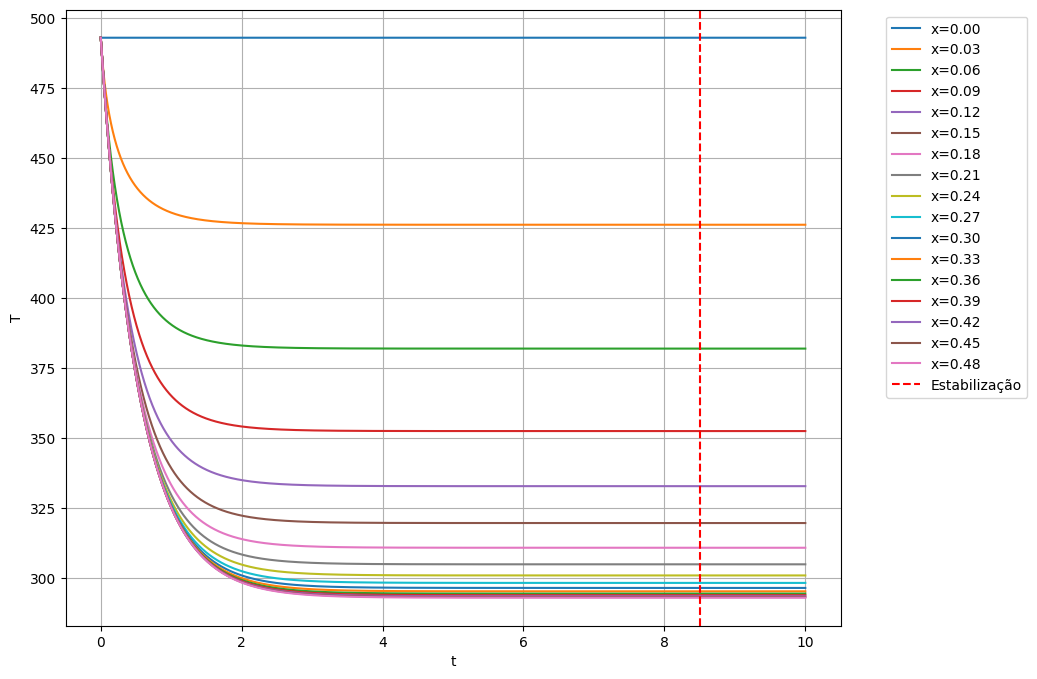

In [80]:
# Gráfico 1: Temperatura vs Tempo para diferentes posições x
plt.figure(figsize=(10, 8))
for i in range(0, n_x, 3):
    plt.plot(sol_questao1.t, sol_questao1.y[i], label=f"x={x[i]:.2f}")

plt.axvline(x=tempo_est, color='red', linestyle='--', label="Estabilização")
plt.xlabel('t')
plt.ylabel('T')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()


2)Questão

In [81]:
def tempo_resfriamento_pontofinal(sol, tolTemp=1e-5):
    # Inicializa o tempo de resfriamento como o último instante de tempo
    tempo_resfriar = sol.t[-1]

    for i in range(1, sol.y.shape[1]):  # Itera sobre os instantes de tempo
        # Calcula o desvio da temperatura em relação à temperatura ambiente
        desvio_temp = np.abs(sol.y[-1, i] - T_s)
        # Verifica se as condições de resfriamento estão satisfeitas
        if desvio_temp < tolTemp:
            tempo_resfriar = sol.t[i]  # Atualiza o tempo de resfriamento
            break

    return tempo_resfriar  # Retorna o tempo de resfriamento


In [82]:
# Função de custos para otimização
def funcao_custos(k):
    k0, k1 = k
    tf = 100.0 # Tempo final de simulação
    intervalo_tempo = np.linspace(0, tf, 10000)
    sol = solve_ivp(edp_dTdt, (0, tf), T0, args=(k0, k1), t_eval=intervalo_tempo, rtol=1e-8, atol=1e-8)
    return tempo_resfriamento_pontofinal(sol)

In [83]:
# Função para encontrar o melhor chute inicial
def encontrar_melhor_chute(limites, num_chutes=1000):
    melhor_tempo = float('inf')
    melhor_chute = None
    melhor_solucao = None

    # Definindo o incremento para gerar os chutes iniciais
    incremento_k0 = (limites[0][1] - limites[0][0]) / num_chutes
    incremento_k1 = (limites[1][1] - limites[1][0]) / num_chutes

    for i in range(num_chutes):
        k_inicial = [
            limites[0][0] + i * incremento_k0,  # Incrementa k0
            limites[1][0] + i * incremento_k1   # Incrementa k1
        ]
        resultado_otimizacao = minimize(funcao_custos, k_inicial, bounds=limites)
        tempo_resfriamento = funcao_custos(resultado_otimizacao.x)

        if tempo_resfriamento < melhor_tempo:
            melhor_tempo = tempo_resfriamento
            melhor_chute = k_inicial
            melhor_solucao = resultado_otimizacao.x

    return melhor_chute, melhor_solucao, melhor_tempo

In [84]:
# Executa a busca pelo melhor chute inicial
limites = [(0, 3.5), (0, 2.0e-9)]
melhor_chute, k_otimizado, melhor_tempo = encontrar_melhor_chute(limites, num_chutes=20)

print(f"Melhor chute inicial: k0 = {melhor_chute[0]:.6f}, k1 = {melhor_chute[1]:.6e}")
print(f"Parâmetros otimizados: k0 = {k_otimizado[0]:.6f}, k1 = {k_otimizado[1]:.6e}")
print(f"Melhor tempo de resfriamento: {melhor_tempo:.2f} segundos")



Melhor chute inicial: k0 = 3.325000, k1 = 1.900000e-09
Parâmetros otimizados: k0 = 3.325000, k1 = 1.900000e-09
Melhor tempo de resfriamento: 4.77 segundos


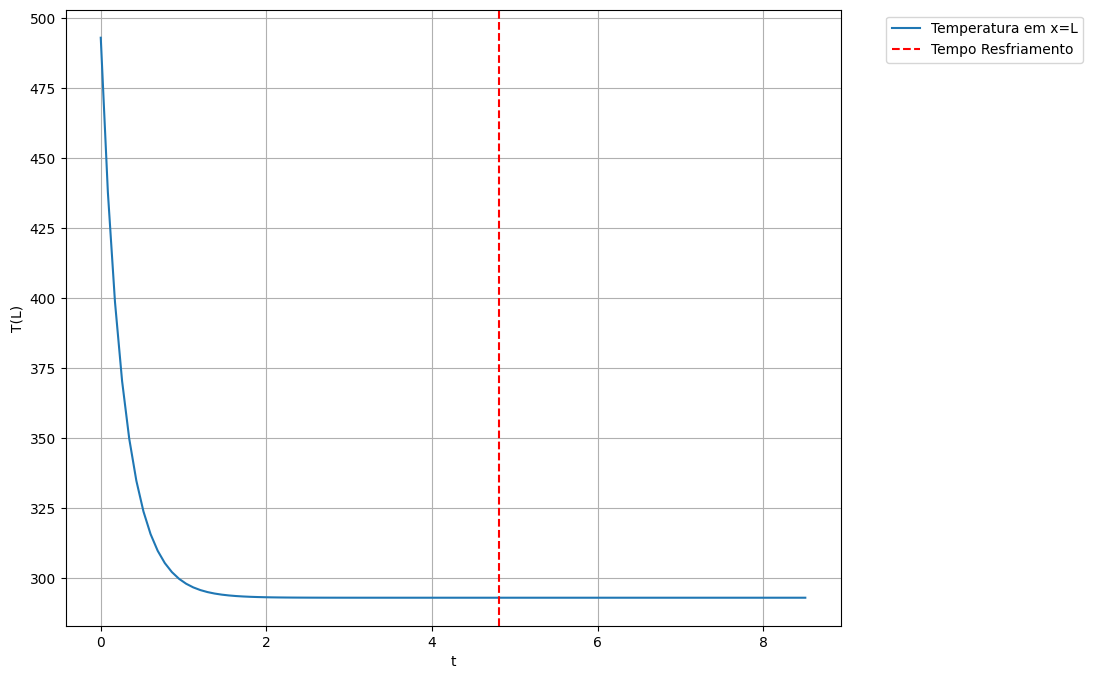

In [85]:
# Simulação com os parâmetros otimizados para visualização
sol_questao2 = solve_ivp(edp_dTdt, (0, tempo_est), T0, args=k_otimizado, t_eval=np.linspace(0, tempo_est, 100), rtol=1e-8, atol=1e-8)

# Gráfico: Temperatura vs Tempo no ponto final do pino (x = L)
plt.figure(figsize=(10, 8))
plt.plot(sol_questao2.t, sol_questao2.y[-1], label=f'Temperatura em x=L')
plt.axvline(x=tempo_resfriamento_pontofinal(sol_questao2), color='red', linestyle='--', label="Tempo Resfriamento")
plt.xlabel('t')
plt.ylabel('T(L)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

3)Questão

In [86]:
tempo_resfriamento1 = funcao_custos(k)
print(f"Tempo mínimo de resfriamento no ponto final: {tempo_resfriamento1:.2f} segundos")

Tempo mínimo de resfriamento no ponto final: 9.49 segundos


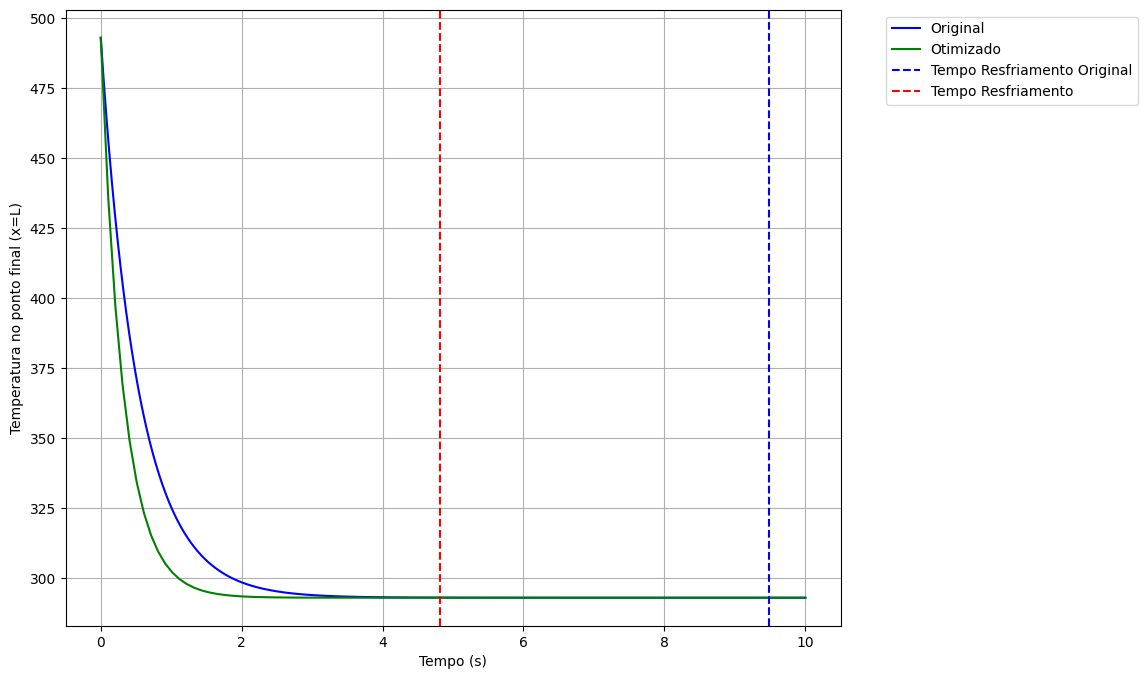

In [87]:
y_interpolated = np.interp(sol_questao1.t, np.linspace(sol_questao1.t[0], sol_questao1.t[-1], len(sol_questao2.y[-1])), sol_questao2.y[-1])

plt.figure(figsize=(10, 8))
plt.plot(sol_questao1.t, sol_questao1.y[-1], label='Original', color='blue')
plt.plot(sol_questao1.t, y_interpolated, label='Otimizado', color='green')
plt.axvline(x=tempo_resfriamento1, color='blue', linestyle='--', label="Tempo Resfriamento Original")
plt.axvline(x=tempo_resfriamento_pontofinal(sol_questao2), color='red', linestyle='--', label="Tempo Resfriamento")
plt.xlabel('Tempo (s)')
plt.ylabel('Temperatura no ponto final (x=L)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

In [88]:
desvio_relativo = np.abs(tempo_resfriamento1 - tempo_resfriamento_pontofinal(sol_questao2)) / tempo_resfriamento1
print(f"Desvio relativo entre os tempos após a otimização: {desvio_relativo * 100:.2f}%")

Desvio relativo entre os tempos após a otimização: 49.31%
